# HSCT survival: Cox proportional hazards model

## Notebook set-up

In [22]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from sklearn.model_selection import train_test_split

import configuration as config
import functions.helper as helper_funcs

pd.set_option('display.max_rows', 500)

# Data files
data_df_file=f'{config.DATA_PATH}/processed/02.1-no_multicollinearity_encoded_all_imputed_data_df.parquet'
raw_data_file=f'{config.DATA_PATH}/raw/train.csv'
feature_types_dict_file=f'{config.DATA_PATH}/processed/01.1-feature_type_dict.pkl'
survival_functions_file=f'{config.DATA_PATH}/processed/04.1-coxPH_survival_functions.parquet'
survival_probabilities_file=f'{config.DATA_PATH}/processed/04.1-coxPH_160_week_survival_probabilities.csv'


## 1. Load data

Feature types:

True numerical features
['donor_age', 'age_at_hct', 'year_hct', 'efs_time']

Ordinal features
['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']

True categorical features
['psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'tce_imm_match', 'rituximab', 'prod_type', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan

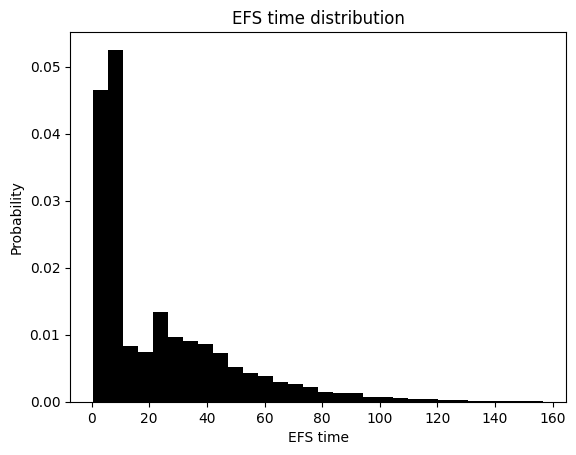

Training features: (28800, 118)


In [2]:
# Load the data
data_df=pd.read_parquet(data_df_file)

# Load and preserve race group for scoring
raw_data=pd.read_csv(raw_data_file)
data_df['race_group']=raw_data['race_group']

with open(feature_types_dict_file, 'rb') as input_file:
    feature_types_dict=pickle.load(input_file)
    
# Load feature type definitions
print('Feature types:\n')
for feature_type, features in feature_types_dict.items():
    print(f'{feature_type}\n{features}\n')

# Combine feature lists for ordinal and true numerical features
numerical_features=feature_types_dict['True numerical features'] + feature_types_dict['Ordinal features']

# Take a quick look at the target
plt.title('EFS time distribution')
plt.hist(data_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('EFS time')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {data_df.shape}')

In [3]:
data_df.head()

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,...,tce_div_match_GvH non-permissive,tce_div_match_HvG non-permissive,tce_div_match_Permissive mismatched,donor_related_Related,donor_related_Unrelated,"melphalan_dose_N/A, Mel not given",cardiac_Yes,pulm_moderate_Yes,efs,race_group
ID,,,,,,,,,,,,,,,,,,,,,
0,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,...,0,0,1,0,1,1,0,0,0,More than one race
1,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,...,0,0,1,1,0,1,0,1,1,Asian
2,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,...,0,0,1,1,0,1,0,0,0,More than one race
3,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,...,0,0,1,0,1,1,0,0,0,White
4,2.0,8.0,6.0,6.0,10.0,2.0,5.0,2.0,2.0,2.0,...,0,0,1,1,0,0,0,0,0,American Indian or Alaska Native


## 2. Data preparation

### 2.1 Train-test split

In [4]:
training, testing=train_test_split(data_df, test_size=0.33, random_state=315)

training_df=pd.DataFrame(training, columns=data_df.columns)
testing_df=pd.DataFrame(testing, columns=data_df.columns)

training_labels_df=training_df[['efs', 'efs_time']]
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)

testing_labels_df=testing_df[['efs', 'efs_time']]
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

### 2.2. Save and remove training & testing race group

In [5]:
training_race_group=training_df['race_group']
testing_race_group=testing_df['race_group']

training_df.drop('race_group', axis=1, inplace=True)
testing_df.drop('race_group', axis=1, inplace=True)

## 3. Cox proportional hazards model

### 3.1. Naive model

In [6]:
cph_model=CoxPHFitter()
cph_model.fit(training_df, duration_col='efs_time', event_col='efs')

/mnt/arkk/kaggle/HSCT_survival/.venv/lib/python3.10/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['gvhd_proph_FK+- others(not MMF,MTX)'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 19296 total observations, 8876 right-censored observations>

### 3.2. Drop low entropy feature

In [7]:
training_df.drop('gvhd_proph_FK+- others(not MMF,MTX)', axis=1, inplace=True)
testing_df.drop('gvhd_proph_FK+- others(not MMF,MTX)', axis=1, inplace=True)

cph_model=CoxPHFitter()
cph_model.fit(training_df, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 19296 total observations, 8876 right-censored observations>

### 3.3. Select features with p < 0.05

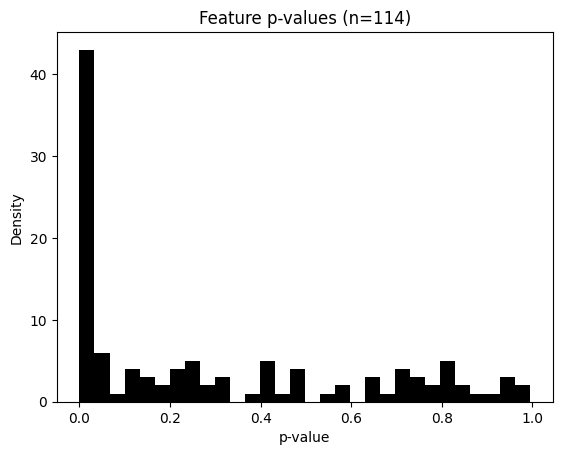

Significant features at alpha = 0.05: 45
Significant features at alpha = 0.001: 25


In [8]:
feature_pvals=cph_model.summary['p']

plt.title(f'Feature p-values (n={len(feature_pvals)})')
plt.hist(feature_pvals, color='black', bins=30)
plt.xlabel('p-value')
plt.ylabel('Density')
plt.show()

significant_features=feature_pvals[feature_pvals < 0.05]
print(f'Significant features at alpha = 0.05: {len(significant_features)}')

significant_features=feature_pvals[feature_pvals < 0.001]
print(f'Significant features at alpha = 0.001: {len(significant_features)}')

In [9]:
training_significant_features_df=training_df[feature_pvals[feature_pvals < 0.05].index].copy()
testing_significant_features_df=testing_df[feature_pvals[feature_pvals < 0.05].index].copy()

training_significant_features_df['efs']=training_df['efs']
training_significant_features_df['efs_time']=training_df['efs_time']
testing_significant_features_df['efs']=testing_df['efs']
testing_significant_features_df['efs_time']=testing_df['efs_time']

cph_model=CoxPHFitter()
cph_model.fit(training_significant_features_df, duration_col='efs_time', event_col='efs')
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 19296 total observations, 8876 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 19296
number of events observed = 10420
   partial log-likelihood = -97445.86
         time fit was run = 2025-02-20 03:15:24 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                             
hla_nmdp_6                           -0.03      0.97      0.02           -0.06            0.01                0.94                1.01
hla_match_a_low                      -0.15      0.86      0.04           -0.22           -0.08                0.80                0.92
comorbidity_score                     0.07      1.07      0.01            0.05            0.08                1.06                1.08
karnofsky_score                      -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
hla_match_drb1_high                   0.28      1.33      0.04            0.21            0.36                1.23                1.43
dri_score                             0.11      1.11      0.01            0.09            0.12                1.10                1.13
cyto_score                            0.06      1.06      0.01            0.04            0.08                1.04                1.08
cyto_score_detail                     0.22      1.25      0.01            0.19            0.25                1.21                1.28
donor_age                             0.00      1.00      0.00           -0.00            0.00                1.00                1.00
age_at_hct                            0.00      1.00      0.00            0.00            0.00                1.00                1.00
year_hct                             -0.04      0.96      0.00           -0.05           -0.03                0.96                0.97
psych_disturb_Yes                     0.09      1.09      0.03            0.03            0.15                1.03                1.16
diabetes_Yes                          0.15      1.16      0.03            0.10            0.20                1.10                1.23
tbi_status_TBI + Cy +- Other          0.14      1.16      0.03            0.09            0.20                1.10                1.22
tbi_status_TBI +- Other, <=cGy        0.23      1.25      0.04            0.15            0.30                1.16                1.35
graft_type_Peripheral blood           0.17      1.18      0.03            0.11            0.22                1.12                1.25
vent_hist_Yes                         0.15      1.17      0.06            0.04            0.27                1.04                1.31
pulm_severe_Yes                       0.21      1.24      0.04            0.14            0.29                1.14                1.33
prim_disease_hct_HD                  -1.61      0.20      0.50           -2.59           -0.63                0.07                0.53
prim_disease_hct_HIS                 -1.08      0.34      0.15           -1.37           -0.79                0.25                0.45
prim_disease_hct_IEA                 -0.67      0.51      0.07           -0.81           -0.53                0.45                0.59
prim_disease_hct_IIS                 -0.95      0.39      0.09           -1.13           -0.77                0.32                0.46
prim_disease_hct_IMD                 -0.41      0.66      0.19           -0.79           -0.03                0.45                0.97
prim_disease_hct_Other leukemia      -0.41      0.67      0.11           -0.63           -0.18                0.53                0.83
prim_disease_hct_PCD                 -0.42      0.66      0.07           -0.56           -0.28                0.57        

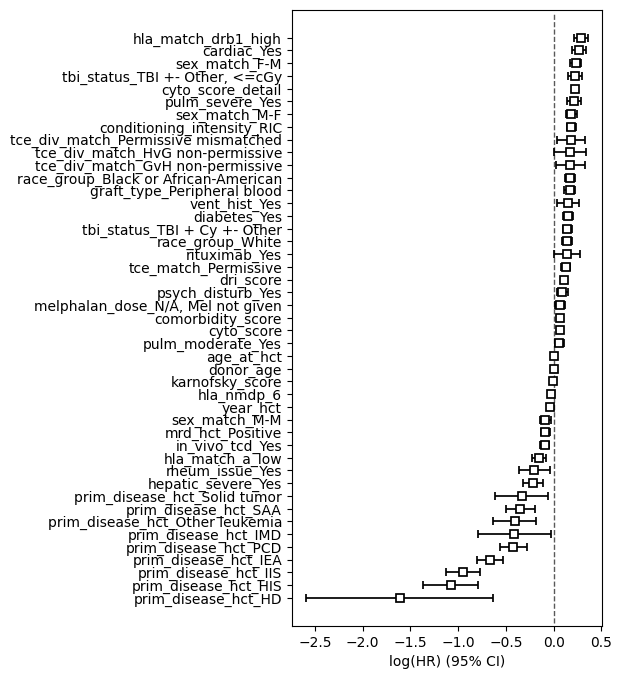

In [10]:
fig=plt.figure(figsize=[4,8])
cph_model.plot(figure=fig)
plt.show()

In [11]:
cph_model.check_assumptions(training_significant_features_df, p_value_threshold=0.001)

The ``p_value_threshold`` is set at 0.001. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 19296 total observations, 8876 right-censored observations>
         test_name = proportional_hazard_test

---
                                           test_statistic      p  -log2(p)
age_at_hct                           km             49.81 <0.005     39.10
                                     rank           49.87 <0.005     39.15
cardiac_Yes                          km              2.44   0.12      3.08
                                     rank            2.44   0.12      3.08
comorbidity_score                    km             94.09 <0.005     71.49
                                     rank           94.13 <0.005     71.52
conditioning_intensity_RIC           km              4.27   0.04      4.69
                                     rank            4.27   0.04      4.68
cyto_score                           km             42.64 <0.005     33.82
                                     rank           42.63 <0.005     33.81
cyto_score_detail                    km             92.90 <0.005     70.62
                                     rank           92.84 <0.005     70.58
diabetes_Yes                         km              1.02   0.31      1.68
                                     rank            1.02   0.31      1.68
donor_age                            km             34.84 <0.005     28.06
                                     rank           34.87 <0.005     28.08
dri_score                            km             43.68 <0.005     34.59
                                     rank           43.70 <0.005     34.61
graft_type_Peripheral blood          km             47.50 <0.005     37.41
                                     rank           47.48 <0.005     37.39
hepatic_severe_Yes                   km             12.10 <0.005     10.95
                                     rank           12.11 <0.005     10.97
hla_match_a_low                      km              8.45 <0.005      8.10
                                     rank            8.44 <0.005      8.09
hla_match_drb1_high                  km              1.57   0.21      2.25
                                     rank            1.56   0.21      2.24
hla_nmdp_6                           km             19.89 <0.005     16.90
                                     rank           19.91 <0.005     16.91
in_vivo_tcd_Yes                      km            271.57 <0.005    200.27
                                     rank          271.46 <0.005    200.19
karnofsky_score                      km            191.90 <0.005    142.55
                                     rank          191.95 <0.005    142.59
melphalan_dose_N/A, Mel not given    km              1.13   0.29      1.80
                                     rank            1.13   0.29      1.80
mrd_hct_Positive                     km              0.05   0.83      0.27
                                     rank            0.05   0.83      0.27
prim_disease_hct_HD                  km              2.66   0.10      3.28
                                     rank            2.67   0.10      3.29
prim_disease_hct_HIS                 km              4.68   0.03      5.03
                                     rank            4.68   0.03      5.03
prim_disease_hct_IEA                 km              6.85   0.01      6.81
                                     rank            6.86   0.01      6.82
prim_disease_hct_IIS                 km              3.28   0.07      3.84
                                     rank            3.28   0.07      3.84
prim_disease_hct_IMD                 km              0.42   0.52      0.95
                                     rank            0.42   0.52      0.95
prim_disease_hct_Other leukemia      km              0.70   0.40      1.31
                                     rank            0.70   0.40      1.32
prim_disease_hct_PCD                 km      



1. Variable 'hla_nmdp_6' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'hla_nmdp_6' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'hla_nmdp_6' using pd.cut, and then specify it in
`strata=['hla_nmdp_6', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'hla_match_a_low' failed the non-proportional test: p-value is 0.0037.

   Advice 1: the functional form of the variable 'hla_match_a_low' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how t

[]

## 4. Survival forecasting

In [12]:
# Predict new survival function for all subjects
training_survival_functions=cph_model.predict_survival_function(training_significant_features_df)
training_survival_df=pd.concat([training_significant_features_df, training_survival_functions.iloc[-1]], axis=1)

# Predict new survival function for all subjects
testing_survival_functions=cph_model.predict_survival_function(testing_significant_features_df)
testing_survival_df=pd.concat([testing_significant_features_df,testing_survival_functions.iloc[-1]], axis=1)

### 4.1. Survival curves

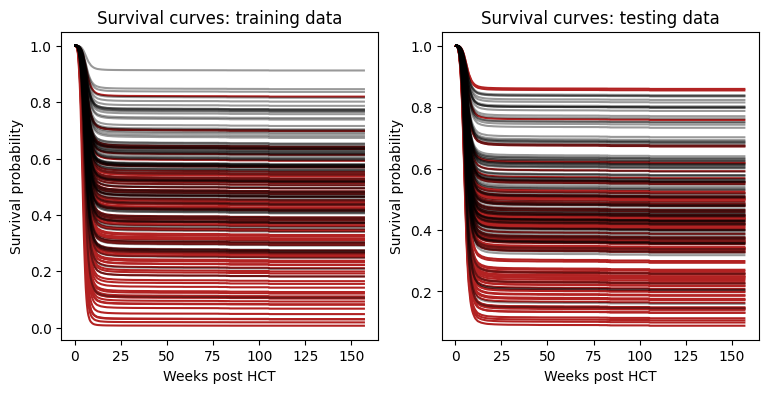

In [13]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_ids=training_significant_features_df[training_significant_features_df['efs'] == 1].index
efs_negative_ids=training_significant_features_df[training_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=training_survival_functions[efs_negative_ids]
efs_positive_survival_functions=training_survival_functions[efs_positive_ids]

axs[0].set_title('Survival curves: training data')

for i in range(100):
    axs[0].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(100):
    axs[0].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[0].set_xlabel('Weeks post HCT')
axs[0].set_ylabel('Survival probability')

efs_positive_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 1].index
efs_negative_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=testing_survival_functions[efs_negative_ids]
efs_positive_survival_functions=testing_survival_functions[efs_positive_ids]

axs[1].set_title('Survival curves: testing data')

for i in range(100):
    axs[1].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(100):
    axs[1].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[1].set_xlabel('Weeks post HCT')
axs[1].set_ylabel('Survival probability')

plt.show()

### 4.2. Survival probability at 160 weeks

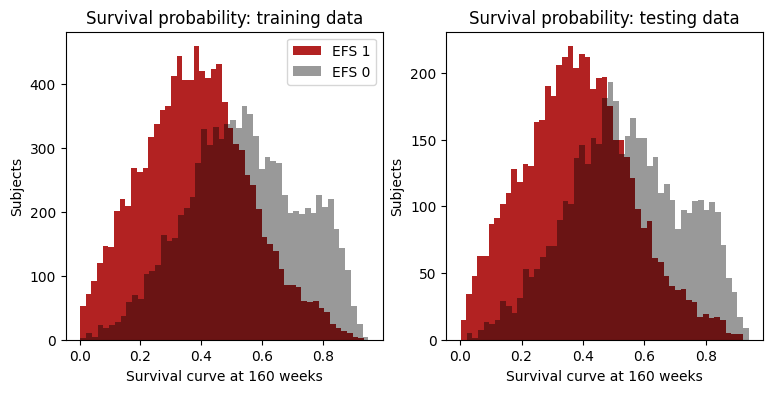

In [14]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Survival probability: training data')
axs[0].hist(efs_positive_df[156.819], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df[156.819], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Survival curve at 160 weeks')
axs[0].set_ylabel('Subjects')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Survival probability: testing data')
axs[1].hist(efs_positive_df[156.819], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df[156.819], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Survival curve at 160 weeks')
axs[1].set_ylabel('Subjects')

plt.show()

### 4.3. Scoring

In [25]:
testing_labels_df.head()

,efs,efs_time
ID,,
1611,0,20.198
7434,1,10.837
18974,1,5.687
4492,1,3.575
14703,1,2.560


In [26]:
testing_survival_df.head()

,hla_nmdp_6,hla_match_a_low,comorbidity_score,karnofsky_score,hla_match_drb1_high,dri_score,cyto_score,cyto_score_detail,donor_age,age_at_hct,...,race_group_White,tce_div_match_GvH non-permissive,tce_div_match_HvG non-permissive,tce_div_match_Permissive mismatched,"melphalan_dose_N/A, Mel not given",cardiac_Yes,pulm_moderate_Yes,efs,efs_time,156.819
1611,5.0,1.0,2.0,90.0,1.0,5.0,2.6,2.4,26.502,13.631,...,0,0,0,1,0,0,0,0,20.198,0.417512
7434,6.0,2.0,1.0,90.0,2.0,2.0,2.0,2.0,30.454,35.444,...,1,0,0,1,1,0,0,1,10.837,0.465040
18974,6.0,2.0,1.0,90.0,2.0,4.0,4.0,4.0,27.352,65.184,...,1,0,0,1,1,0,0,1,5.687,0.098930
4492,4.0,2.0,0.0,70.0,2.0,2.0,4.0,2.6,23.891,49.895,...,0,0,0,1,1,0,0,1,3.575,0.426272
14703,6.0,2.0,3.0,60.0,2.0,0.0,1.0,2.0,54.567,66.429,...,0,0,1,0,1,0,1,1,2.560,0.363150


In [24]:
scoring_results=helper_funcs.score_predictions(
    model_description=f'CoxPH',
    predictions=testing_survival_df[156.819],
    labels_df=testing_labels_df,
    race_group=testing_race_group
)

print(scoring_results)

{'Model': ['CoxPH'], 'RMSE': [33.54254976544544], 'C-index': [np.float64(0.3373502308702467)], 'Stratified C-index': [0.32345638754545875]}


## 5. Save survival probabilities

### 5.1. Prep. complete dataset for Cox-PH regression

In [15]:
data_df.drop('gvhd_proph_FK+- others(not MMF,MTX)', axis=1, inplace=True)

efs_time=data_df['efs_time']
efs=data_df['efs']
data_df=data_df[feature_pvals[feature_pvals < 0.05].index].copy()
data_df['efs_time']=efs_time
data_df['efs']=efs

### 5.2. Fit Cox PH model

In [16]:
cph_model=CoxPHFitter()
cph_model.fit(data_df, duration_col='efs_time', event_col='efs')
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 28800 total observations, 13268 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 28800
number of events observed = 15532
   partial log-likelihood = -151463.58
         time fit was run = 2025-02-20 03:15:56 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                             
hla_nmdp_6                           -0.03      0.97      0.01           -0.05            0.00                0.95                1.00
hla_match_a_low                      -0.17      0.85      0.03           -0.22           -0.11                0.80                0.90
comorbidity_score                     0.06      1.07      0.00            0.06            0.07                1.06                1.08
karnofsky_score                      -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
hla_match_drb1_high                   0.29      1.34      0.03            0.23            0.35                1.26                1.42
dri_score                             0.10      1.11      0.01            0.09            0.11                1.09                1.12
cyto_score                            0.07      1.07      0.01            0.05            0.08                1.05                1.09
cyto_score_detail                     0.22      1.24      0.01            0.19            0.24                1.21                1.27
donor_age                            -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
age_at_hct                            0.00      1.00      0.00            0.00            0.00                1.00                1.00
year_hct                             -0.04      0.96      0.00           -0.05           -0.04                0.95                0.96
psych_disturb_Yes                     0.09      1.09      0.02            0.04            0.13                1.04                1.14
diabetes_Yes                          0.13      1.14      0.02            0.09            0.17                1.09                1.19
tbi_status_TBI + Cy +- Other          0.13      1.14      0.02            0.09            0.17                1.09                1.19
tbi_status_TBI +- Other, <=cGy        0.21      1.23      0.03            0.15            0.27                1.16                1.31
graft_type_Peripheral blood           0.19      1.21      0.02            0.14            0.23                1.15                1.26
vent_hist_Yes                         0.14      1.15      0.05            0.04            0.23                1.04                1.26
pulm_severe_Yes                       0.26      1.29      0.03            0.20            0.32                1.22                1.38
prim_disease_hct_HD                  -1.52      0.22      0.41           -2.32           -0.72                0.10                0.49
prim_disease_hct_HIS                 -1.10      0.33      0.12           -1.34           -0.86                0.26                0.42
prim_disease_hct_IEA                 -0.80      0.45      0.06           -0.92           -0.68                0.40                0.51
prim_disease_hct_IIS                 -0.87      0.42      0.07           -1.01           -0.73                0.36                0.48
prim_disease_hct_IMD                 -0.45      0.64      0.15           -0.75           -0.14                0.47                0.87
prim_disease_hct_Other leukemia      -0.46      0.63      0.09           -0.64           -0.28                0.53                0.76
prim_disease_hct_PCD                 -0.48      0.62      0.06           -0.60           -0.36                0.55      

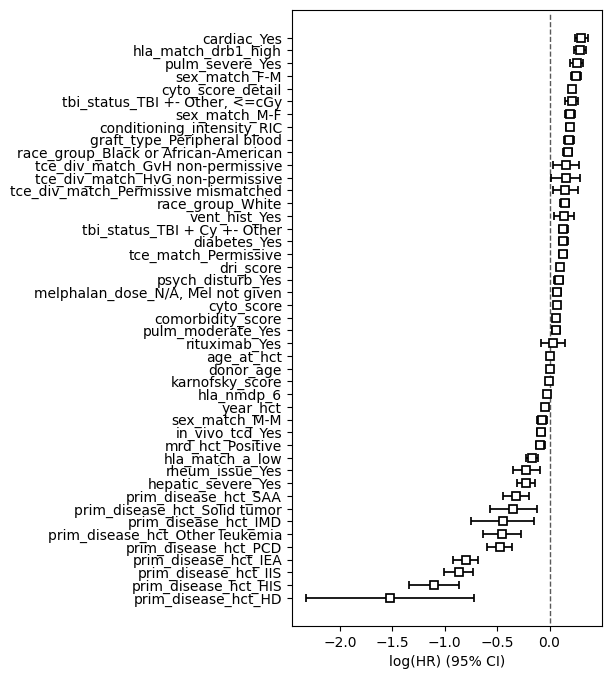

In [17]:
fig=plt.figure(figsize=[4,8])
cph_model.plot(figure=fig)
plt.show()

### 5.3. Forecast survival curve for all participants

In [18]:
survival_functions=cph_model.predict_survival_function(data_df)
survival_functions.to_parquet(survival_functions_file)
survival_functions.head()

,0,1,2,3,4,5,6,7,8,9,...,28790,28791,28792,28793,28794,28795,28796,28797,28798,28799
0.333,0.999992,0.999964,0.999994,0.999971,0.999973,0.999939,0.999978,0.999982,0.999967,0.999979,...,0.999976,0.999960,0.999991,0.999995,0.999974,0.999982,0.999951,0.999941,0.999984,0.999988
0.482,0.999983,0.999928,0.999987,0.999941,0.999947,0.999878,0.999955,0.999964,0.999935,0.999959,...,0.999952,0.999919,0.999981,0.999990,0.999948,0.999964,0.999902,0.999883,0.999967,0.999976
0.523,0.999975,0.999893,0.999981,0.999912,0.999920,0.999817,0.999933,0.999947,0.999902,0.999938,...,0.999928,0.999879,0.999972,0.999985,0.999922,0.999946,0.999853,0.999824,0.999951,0.999964
0.533,0.999966,0.999857,0.999974,0.999883,0.999893,0.999756,0.999910,0.999929,0.999869,0.999917,...,0.999904,0.999839,0.999963,0.999980,0.999896,0.999928,0.999804,0.999766,0.999935,0.999953
0.543,0.999958,0.999821,0.999968,0.999853,0.999867,0.999695,0.999888,0.999911,0.999836,0.999896,...,0.999880,0.999798,0.999953,0.999975,0.999870,0.999909,0.999755,0.999707,0.999919,0.999941


### 5.4. Survival probabilities at 160 weeks for all participants

In [19]:
survival_probabilities=survival_functions.iloc[-1]
survival_probabilities.rename('coxph_survival_probabilities', inplace=True)
survival_probabilities

0        0.801002
1        0.388070
2        0.843059
3        0.460100
4        0.494591
           ...   
28795    0.619468
28796    0.273798
28797    0.212873
28798    0.650649
28799    0.731399
Name: coxph_survival_probabilities, Length: 28800, dtype: float64

### 5.5. Save predicted survival curves & probabilities

In [20]:
survival_functions.to_parquet(survival_functions_file)
survival_probabilities.to_csv(survival_probabilities_file, index=False)